<a href="https://colab.research.google.com/github/crystaljwang/tm11005_aip/blob/main/AIP_Segmentation_total.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Exercise 1 Segmentation of metastases.

The purpose of this exercise is to segment metastases in the liver and obtain the size of the largest metastasis. To this end, you will need to segment two structures:

1) a segmentation the liver

2) a segmentation of the metastases

Load the image 'livermetastases.jpg'. Do not forget to convert it to a grayscale, double type.
Crop the image to the part  [200:399];[200:399] .
Make a mask for the liver, you can use tresholding and/or region growing
Make a mask for the metastases: use morphological operations to optimize the result. Note that there is not a single 'correct' solution, try to find a series of operations which gives you a good final segmentation. Create an image after every step and output the results as shown below. Please also explain why you decided to use these steps.
Determine the size of the largest metastasis. Assume the voxel size is  0.4∗0.4∗3  mm 3 

In [1]:
# Run this to use from colab environment
!git clone https://github.com/crystaljwang/tm11005_aip

Cloning into 'tm11005_aip'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 7.11 MiB | 3.82 MiB/s, done.


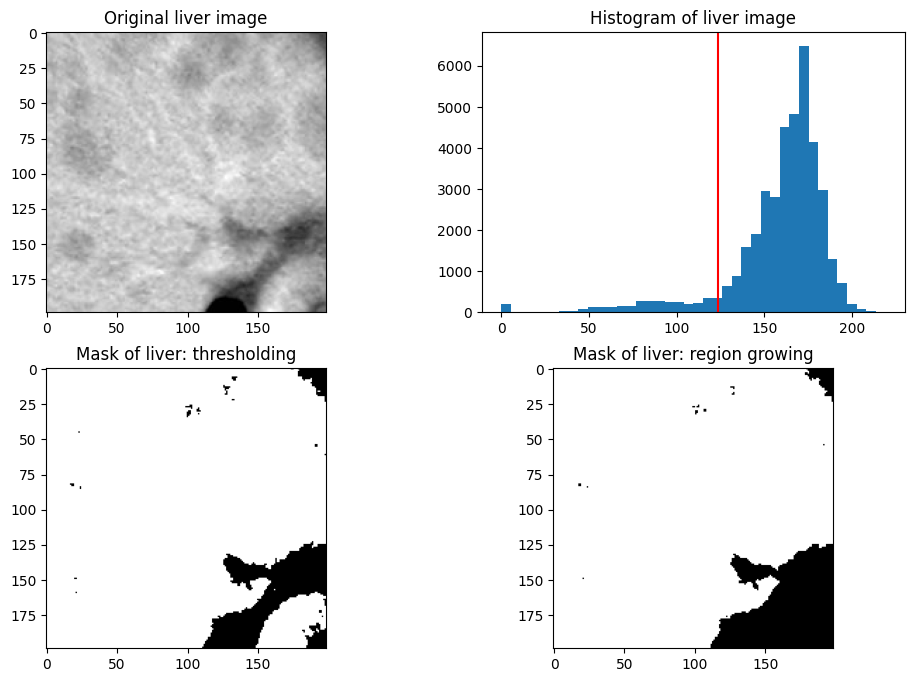

In [195]:
# Excercise 1.1 answer

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from imageio.v3 import imread
from skimage.morphology import disk, dilation, erosion, binary_opening, reconstruction
from skimage.measure import label, regionprops
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import flood_fill, flood

image = np.asarray(imread('tm11005_aip/data/livermetastases.jpg'), dtype = float)[200:399,200:399,:]
image = rgb2gray(image)
threshold = threshold_otsu(image)

# Mask of liver using thresholding
mask_liver_thr = np.zeros(image.shape)
mask_liver_thr[image > threshold] = 1

# Mask of liver using region growing
mask_liver_rg = flood(image, (100,75), connectivity = 1, tolerance = 0.22*255)

# Plot figures
plt.rcParams['figure.figsize'] = [12, 8] # bump up the figure size a bit
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(image, cmap='gray')
axs[0,0].set_title('Original liver image')

axs[0,1].hist(image.ravel(), 40)
axs[0,1].set_title('Histogram of liver image')
axs[0,1].axvline(threshold, color='r')

axs[1,0].imshow(mask_liver_thr, cmap='gray')
axs[1,0].set_title('Mask of liver: thresholding')

axs[1,1].imshow(mask_liver_rg, cmap='gray')
axs[1,1].set_title('Mask of liver: region growing')

plt.show()

# In this case, I would prefer to use region growing, as thresholding also 
# picks up a structure with similar intensity (which looks like it's part of the 
# small intestine, so not liver tissue).

The metastasis with the largest size is 743 voxels, or 356.6 mm³.


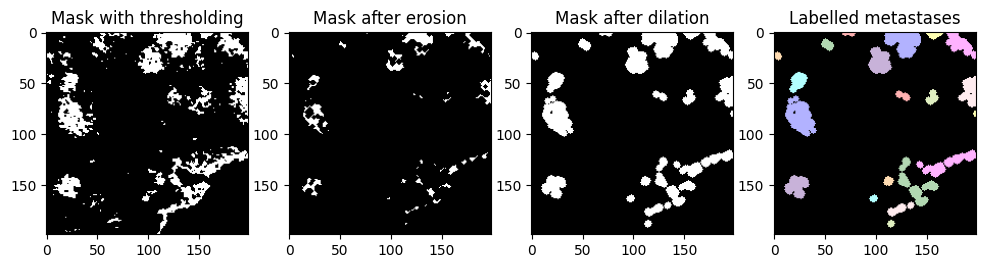

In [204]:
# Exercise 1.2 answer

# Use only the segmented liver part of the original image to threshold the metastases
liver_image = image*mask_liver_rg
mask_metas_thr = np.zeros(liver_image.shape)
mask_metas_thr[(liver_image < 150) & (liver_image > 115)] = 1

# Opening
mask_ero = erosion(mask_metas_thr, disk(2))
mask_metas = dilation(mask_ero, disk(3))

# Determine the size of the largest metastasis
labels = label(mask_metas)
image_label_overlay = label2rgb(labels, image=mask_metas, bg_label=0)

areas = []
for meta in regionprops(labels):
    areas.append(meta.area)

voxel_size = 0.4*0.4*3  # in mm
largest_meta = max(areas) * voxel_size
print(f'The metastasis with the largest size is {max(areas)} voxels, or {largest_meta:.1f} mm\u00B3.')

# Plot figures
fig, axs = plt.subplots(1,4)
axs[0].imshow(mask_metas_thr, cmap='gray')
axs[0].set_title('Mask with thresholding')

axs[1].imshow(mask_ero, cmap='gray')
axs[1].set_title('Mask after erosion')

axs[2].imshow(mask_metas, cmap='gray')
axs[2].set_title('Mask after dilation')

axs[3].imshow(image_label_overlay)
axs[3].set_title('Labelled metastases')

plt.show()

# I use thresholding to segment the metastases, as region growing requires 
# selection of a seed for every single metastasis, which is time consuming and
# dependent on difficult visual evaluation of the metastases.

# I used a disk radius of 2 for erosion to remove the edges of the liver in 
# the lower right corner of the figures from the mask so that these edges 
# would not be counted as 1 large metastasis. Then, I used dilation to grow
# the remaining metastases back to their real size.

# Exercise 2 Atlasses Weighted probability

Create and visualize the atlas that corresponds to the cerebellum (C), the posterior temporal lobe (TL) and the lingual gyrus (LG), where the probabilities are combined using weights: the probabilities are scaled with the weights w_C, w_TL and w_LG, which corresponds to the sizes (volumes) of each corresponding region.

Use image_collection.concatenate() to concatenate all the slices into one array to compute the weights

Create a stack of the weighted probability maps of the three region and show the images for three slices.

In [199]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imread_collection
from plotly.subplots import make_subplots

# Please move brain_images.zip to Bestanden in the Google Colab environment
# First we load the images in an image_collection
!unzip brain_images.zip;

Archive:  brain_images.zip
   creating: brain_images/atlases/
   creating: brain_images/atlases/MaxProbMap/
  inflating: brain_images/atlases/MaxProbMap/Hammers_mith-n30r95-MaxProbMap-full-MNI152-SPM12_t001_z001.png  
  inflating: brain_images/atlases/MaxProbMap/Hammers_mith-n30r95-MaxProbMap-full-MNI152-SPM12_t001_z002.png  
  inflating: brain_images/atlases/MaxProbMap/Hammers_mith-n30r95-MaxProbMap-full-MNI152-SPM12_t001_z003.png  
  inflating: brain_images/atlases/MaxProbMap/Hammers_mith-n30r95-MaxProbMap-full-MNI152-SPM12_t001_z004.png  
  inflating: brain_images/atlases/MaxProbMap/Hammers_mith-n30r95-MaxProbMap-full-MNI152-SPM12_t001_z005.png  
  inflating: brain_images/atlases/MaxProbMap/Hammers_mith-n30r95-MaxProbMap-full-MNI152-SPM12_t001_z006.png  
  inflating: brain_images/atlases/MaxProbMap/Hammers_mith-n30r95-MaxProbMap-full-MNI152-SPM12_t001_z007.png  
  inflating: brain_images/atlases/MaxProbMap/Hammers_mith-n30r95-MaxProbMap-full-MNI152-SPM12_t001_z008.png  
  inflating:

The right cerebellum consists of 128246.0 voxels.
The posterior temporal lobe consists of 121851.0 voxels.
The lingual gyrus consists of 44752.0 voxels.


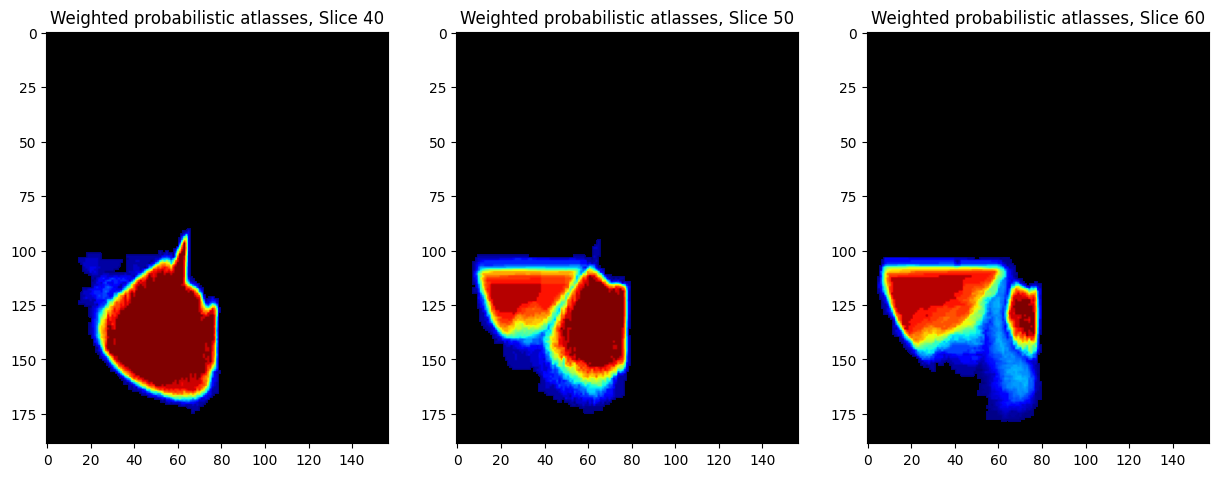

In [253]:
a01_data = imread_collection('brain_images/subjects/a01/*')   

# Load the probability maps that correspond to the right 
# cerebellum (C), posterior temporal lobe (TL),
# and lingual gyrus (LG)
data_probC  = imread_collection(f"brain_images/regions/probmap-full-r17-cerebellum_R/*")
data_probTL = imread_collection(f"brain_images/regions/probmap-full-r31-TL_posterior_temporal_lobe_R/*")
data_probLG = imread_collection(f"brain_images/regions/probmap-full-r65-OL_lingual_gyrus_R/*")

data_probC_conc = data_probC.concatenate()
data_probTL_conc = data_probTL.concatenate()
data_probLG_conc = data_probLG.concatenate()

mask_probC = np.zeros(data_probC_conc.shape)
mask_probC[data_probC_conc != 0] = 1

mask_probTL = np.zeros(data_probTL_conc.shape)
mask_probTL[data_probTL_conc != 0] = 1

mask_probLG = np.zeros(data_probLG_conc.shape)
mask_probLG[data_probLG_conc != 0] = 1

# Calculate weights/sizes of each region
w_C = np.sum(mask_probC)
w_TL = np.sum(mask_probTL)
w_LG = np.sum(mask_probLG)

print(f'The right cerebellum consists of {w_C} voxels.')
print(f'The posterior temporal lobe consists of {w_TL} voxels.')
print(f'The lingual gyrus consists of {w_LG} voxels.')

# Calculate weighted probability atlasses
data_probC = data_probC * w_C
data_probTL = data_probTL * w_TL
data_probLG = data_probLG * w_LG

n_slice = 39

combi = data_probC[n_slice], data_probTL[n_slice], data_probLG[n_slice]
data_combi = np.stack(combi, axis=2)  # stack along z-axis

mask_combi = np.argmax(data_combi, axis=2)
max_combi = np.amax(data_combi, axis=2)
mask_combi[max_combi == 0] = 0

cmap = plt.get_cmap('jet')
cmap.set_under(color='black')
cmap.set_bad(color='black')

plt.rcParams['figure.figsize'] = [15, 8]
fig, axs = plt.subplots(1,3)
axs[0].imshow(max_combi, cmap=cmap, vmin=10**-1)
axs[0].set_title(f"Weighted probabilistic atlasses, Slice {n_slice + 1}")

n_slice = 49

combi = data_probC[n_slice], data_probTL[n_slice], data_probLG[n_slice]
data_combi = np.stack(combi, axis=2)  # stack along z-axis

mask_combi = np.argmax(data_combi, axis=2)
max_combi = np.amax(data_combi, axis=2)
mask_combi[max_combi == 0] = 0

axs[1].imshow(max_combi, cmap=cmap, vmin=10**-1)
axs[1].set_title(f"Weighted probabilistic atlasses, Slice {n_slice + 1}")

n_slice = 59

combi = data_probC[n_slice], data_probTL[n_slice], data_probLG[n_slice]
data_combi = np.stack(combi, axis=2)  # stack along z-axis

mask_combi = np.argmax(data_combi, axis=2)
max_combi = np.amax(data_combi, axis=2)
mask_combi[max_combi == 0] = 0

axs[2].imshow(max_combi, cmap=cmap, vmin=10**-1)
axs[2].set_title(f"Weighted probabilistic atlasses, Slice {n_slice + 1}")

plt.show()
